Data Sources: WHO, CDC, World Bank and UN.

In [871]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier


#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import matplotlib as mpl

import missingno as msno
from p5 import *


import datetime as dt
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
std=StandardScaler()
import warnings
warnings.filterwarnings("ignore")

In [872]:
df = pd.read_csv('Leading Causes of Death in Egypt.csv')
df.head()

,Death Causes,Deaths,Percentage%,"Rate per 100,000",World Rank/183,Cause Effect
0,Coronary Heart Disease,163171.0,29.38,271.69,15,NO
1,Liver Disease,68866.0,12.40,116.08,1,NO
2,Stroke,59445.0,10.70,101.05,53,NO
3,Alzheimers & Dementia,17957.0,3.23,36.09,29,NO
4,Kidney Disease,18279.0,3.29,29.87,32,NO


In [873]:
df = df.replace({'Cause Effect': {'YES':1, 'NO':0}})
df.head()

,Death Causes,Deaths,Percentage%,"Rate per 100,000",World Rank/183,Cause Effect
0,Coronary Heart Disease,163171.0,29.38,271.69,15,0
1,Liver Disease,68866.0,12.40,116.08,1,0
2,Stroke,59445.0,10.70,101.05,53,0
3,Alzheimers & Dementia,17957.0,3.23,36.09,29,0
4,Kidney Disease,18279.0,3.29,29.87,32,0


In [874]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Death Causes      51 non-null     object 
 1   Deaths            51 non-null     float64
 2   Percentage%       51 non-null     float64
 3   Rate per 100,000  51 non-null     float64
 4   World Rank/183    51 non-null     int64  
 5   Cause Effect      51 non-null     int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 2.5+ KB


In [875]:
df.duplicated().sum()

0

In [876]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
Cause Effect,0,0.0
World Rank/183,0,0.0
"Rate per 100,000",0,0.0
Percentage%,0,0.0
Deaths,0,0.0
Death Causes,0,0.0


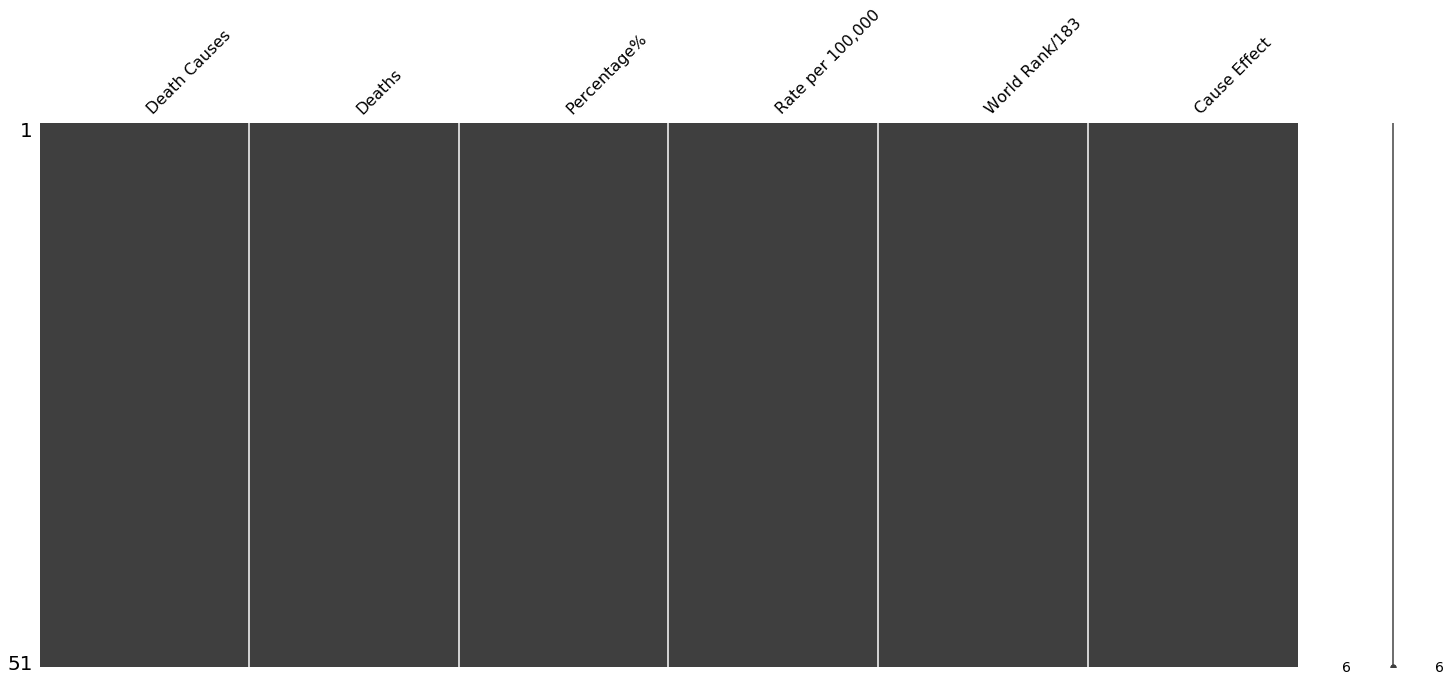

In [877]:
msno.matrix(df)

In [878]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Deaths,51.0,10722.275471,25346.977791,5.049,1334.500,3667.00,7071.50,163171.00
Percentage%,51.0,2.010196,4.552531,0.070,0.280,0.68,1.88,29.38
"Rate per 100,000",51.0,23.040000,58.704917,0.560,2.125,5.19,11.08,308.00
World Rank/183,51.0,81.372549,46.926735,1.000,49.000,82.00,103.00,179.00
Cause Effect,51.0,0.137255,0.347540,0.000,0.000,0.00,0.00,1.00


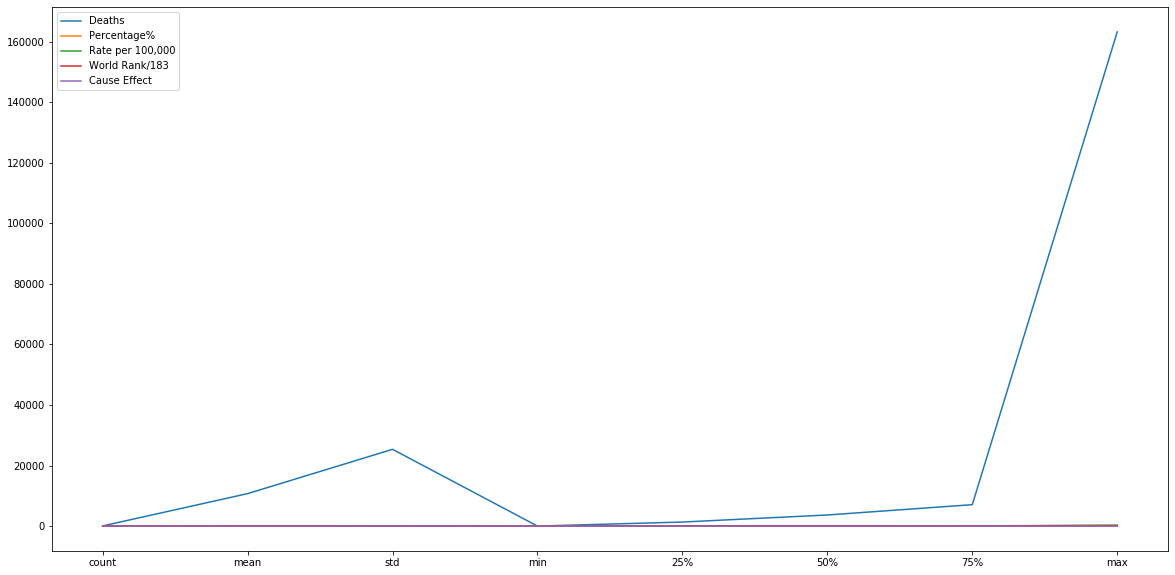

In [879]:
df.describe().plot()

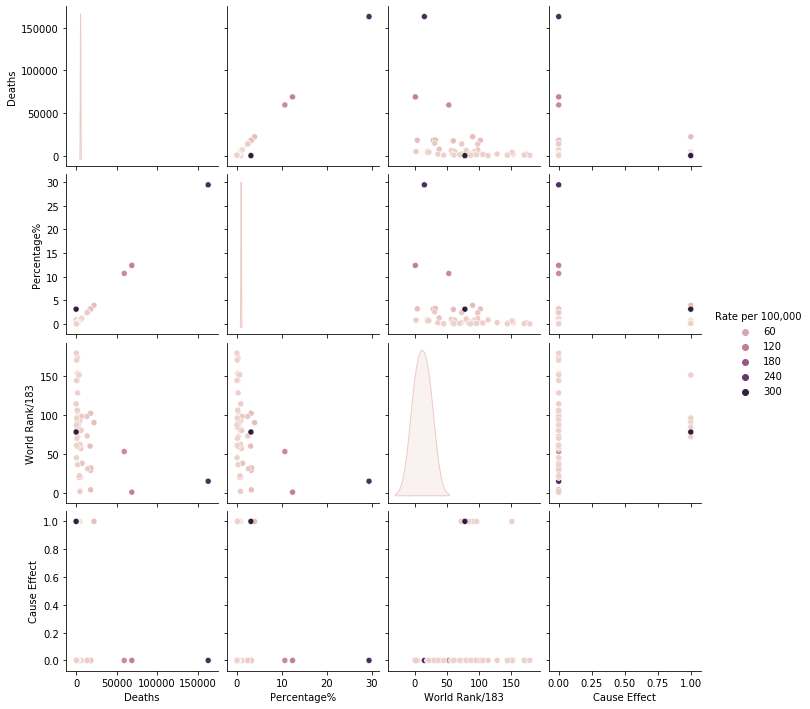

In [880]:
sns.pairplot(df, hue='Rate per 100,000')

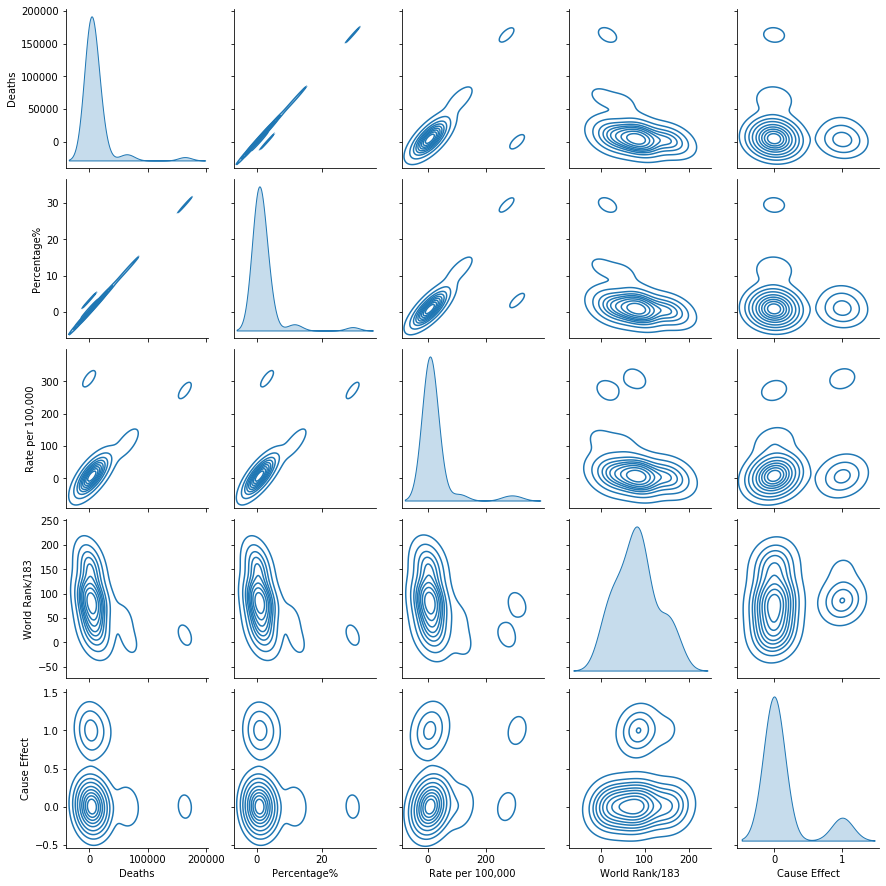

In [881]:
sns.pairplot(df, kind='kde')

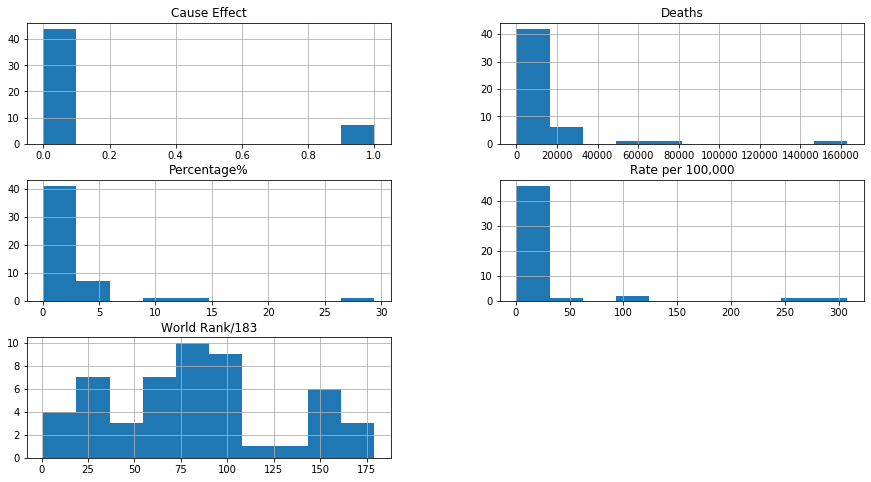

In [882]:
df.hist(figsize=(15,8))
plt.show()

In [883]:
px.treemap(df, path=['Percentage%','Deaths','Rate per 100,000'], values='Rate per 100,000')

In [884]:
y = df['Cause Effect'] 
print(f"There is:  {round(y.value_counts(normalize=True)[1]*100,2)}%  --> ({y.value_counts()[1]} of the death Leading Causes affect others)\nًِWhile: {round(y.value_counts(normalize=True)[0]*100,2)}%  --> ({y.value_counts()[0]} doesn't affect)")

There is:  13.73%  --> (7 of the death Leading Causes affect others)
ًِWhile: 86.27%  --> (44 doesn't affect)


In [885]:
df['Cause Effect'].iplot(kind='hist')

In [886]:
numerical= df.select_dtypes('number').columns

categorical = df.select_dtypes('object').columns


print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')


Numerical Columns:  Index(['Deaths', 'Percentage%', 'Rate per 100,000', 'World Rank/183',
       'Cause Effect'],
      dtype='object')


Categorical Columns: Index(['Death Causes'], dtype='object')


 Target Variable

 Numerical Features

In [887]:
df[numerical].describe()

,Deaths,Percentage%,"Rate per 100,000",World Rank/183,Cause Effect
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,10722.275471,2.010196,23.040000,81.372549,0.137255
std,25346.977791,4.552531,58.704917,46.926735,0.347540
min,5.049000,0.070000,0.560000,1.000000,0.000000
25%,1334.500000,0.280000,2.125000,49.000000,0.000000
50%,3667.000000,0.680000,5.190000,82.000000,0.000000
75%,7071.500000,1.880000,11.080000,103.000000,0.000000
max,163171.000000,29.380000,308.000000,179.000000,1.000000


In [888]:
df[numerical].iplot(kind='hist');

In [889]:
df[numerical].iplot(kind='histogram',subplots=True,bins=50)

In [890]:
skew_limit = 0.2 # This is our threshold-limit to evaluate skewness. Overall below abs(5) seems acceptable for the linear models. 
skew_vals = df[numerical].skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

Deaths              4.901379
Percentage%         4.886697
Rate per 100,000    4.065901
Cause Effect        2.172703
World Rank/183      0.268354
dtype: float64

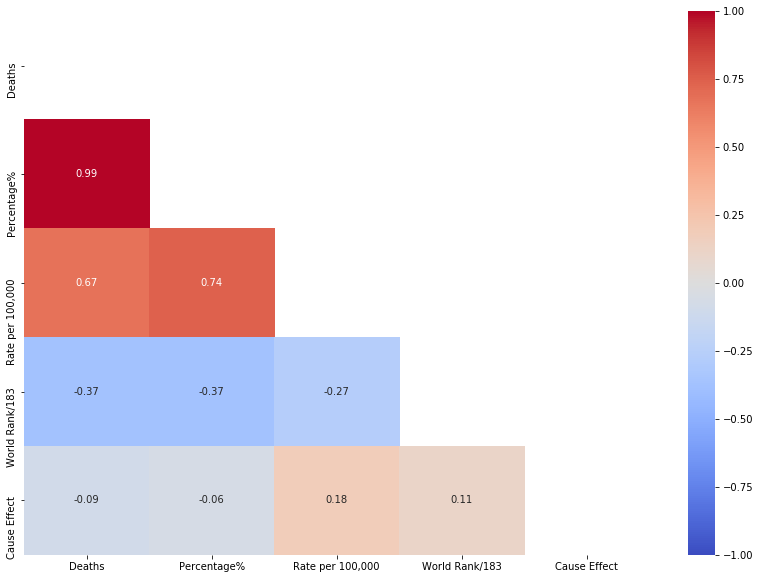

In [891]:
numerical1= df.select_dtypes('number').columns


matrix = np.triu(df[numerical1].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df[numerical1].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);



Categorical Features

In [892]:
df[categorical].head()

,Death Causes
0,Coronary Heart Disease
1,Liver Disease
2,Stroke
3,Alzheimers & Dementia
4,Kidney Disease


In [893]:
df[categorical].describe()

,Death Causes
count,51
unique,51
top,Inflammatory/Heart
freq,1


In [894]:
df[categorical].nunique()

Death Causes    51
dtype: int64

    So far so good. No zero variance and no extremely high variance compared with the high rate of data.


 MODEL SELECTION

Prediction using Different Machine Learning Models

    first We'll use dummy Catboost module to hyperparameter tuning for Catboost

 CATBOOST

In [895]:
accuracy =[]
model_names =[]


X= df.drop('Cause Effect', axis=1)
y= df['Cause Effect']
categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False,random_state=0,
                          objective= 'CrossEntropy',
    colsample_bylevel= 0.04292240490294766,
    depth= 10,
    boosting_type= 'Plain',
    bootstrap_type= 'MVS')

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df6

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       0.00      0.00      0.00         2

    accuracy                           0.88        16
   macro avg       0.44      0.50      0.47        16
weighted avg       0.77      0.88      0.82        16



,Accuracy
Catboost_tuned,0.875



     second we will use sklearn.model_selection to get the Label Distributions: 

In [896]:
Rate = df['Cause Effect']
Percentage = df['Percentage%']


df.drop(['Cause Effect', 'Percentage%'], axis=1, inplace=True)
df.insert(0, 'Cause Effect', Rate)
df.insert(1, 'Percentage%', Percentage)


# Rate and Percentage are Scaled!

df.head()

,Cause Effect,Percentage%,Death Causes,Deaths,"Rate per 100,000",World Rank/183
0,0,29.38,Coronary Heart Disease,163171.0,271.69,15
1,0,12.40,Liver Disease,68866.0,116.08,1
2,0,10.70,Stroke,59445.0,101.05,53
3,0,3.23,Alzheimers & Dementia,17957.0,36.09,29
4,0,3.29,Kidney Disease,18279.0,29.87,32


Splitting the Data (Original DataFrame)

In [897]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

print(round(df['Cause Effect'].value_counts()[0]/len(df) * 100,2), '% of the dataset are not contagious')
print(round(df['Cause Effect'].value_counts()[1]/len(df) * 100,2), '% of the dataset are contagious')

X = df.drop('Cause Effect', axis=1)
y = df['Cause Effect']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

86.27 % of the dataset are not contagious
13.73 % of the dataset are contagious
Train: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] Test: [ 0  1  2  3  4  5  6  7  8  9 25]
Train: [ 0  1  2  3  4  5  6  7  8  9 19 20 21 22 23 24 25 26 27 28 29 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] Test: [10 11 12 13 14 15 16 17 18 30]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 25 29 30 31 32
 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] Test: [19 20 21 22 23 24 26 27 28 35]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30 35 40 42 43 44 45 46 47 48 49 50] Test: [29 31 32 33 34 36 37 38 39 41]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41] Test: [40 42 43 44 45 46 47 48 49 50]
-----------------------------------------------------------------



Let's predict the increase of average rate using KNeighborsRegressor model

In [994]:
# example of evaluating a knn model on the housing regression dataset
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

# load the dataset
df = read_csv('Leading Causes of Death in Egypt.csv', header=None)
data = df.values
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
try:
    # define model
    model = KNeighborsRegressor()
    # fit model
    model.fit(X_train, y_train)
    # make predictions
    yhat = model.predict(X_test)
    # evaluate predictions
    mae = mean_absolute_error(y_test, yhat)
except ValueError:
    print('Mean Absolute Error (mae)')
    print('Rate Of Increase: %.3f' % mae,'%')


(52, 5) (52,)
(36, 5) (16, 5) (36,) (16,)
Mean Absolute Error (mae)
Rate Of Increase: 4.488 %


In [1000]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
Accuracy = datasets.load_wine()
X = Accuracy.data
y = Accuracy.target
dtree = DecisionTreeClassifier()
Model_Accuracy = cross_val_score(dtree, X, y, scoring="accuracy").mean()
print('Model Accuracy:',Model_Accuracy *100, '%')

Model Accuracy: 86.52380952380952 %


<font size="10">important mention</font>
          
          

This statistics had been recorded in 2018 from the WORLD HEALTH RANKINGS of the world life expectancy in details such 
as(world rank, percentage, rate and deaths) as we can see in the previous dataset, since the last recorded statics listed in 2020 with the Total cases rate only without any details as we can see in the following blank, Hence from the the previous and following statics of 2018 and 2020 we can check the module accuracy in a specific row only as an example:

<font size="3">Coronary Heart Disease in egypt in 2018: 271,690 cases
as we saw earlier the model shown the Rate Of Increase as: 4.433 % so 4.433 of 271.690 = 12044.0177 cases    
    
So, 12044.0177 + (271690 Last record state) = 283,734.0177 cases.</font>

<font size="3" color='red'>And the last recorded cases in 2020 for Coronary Heart Disease was 288,790 cases, which is almost nearly expectation record between the model and the real recorded cases as the model has a 86.52% of Accuracy. </font>
